# This is the control room for A2C training with discrete action-space
It will allow you to..
* Play around with an n-step A2C agent (**I**), follow it's live performance and visualize the learned policy (**II**)
* Get an insight into how different agent configurations affect performance and convergence stability (**III** )

### How to
* If you want to see the agent training in live just follow the notebook instructions in the order presented
* If you are in a hurry and are just interested in the results this A2C- implementation achieved, pfast forward to (**III**)
* For details on the methods that are used to train the agent, please refer to the 'train_discrete.py' and 'a2cagent_discrete.py' scripts, you will find documentation there
* For more theoretical background on the A2C method, please refer to the **FOUNDATIONS** section in the README.md file

In [2]:
%%capture 
#hide loading information

#import python files and modules
import tensorflow as tf
import datetime, os
import a2cagent_discrete
import train_discrete as train
;

## I Use the A2C to learn a control task
#### Enable TensorBoard

In [ ]:
%load_ext tensorboard

#### Initialize Training Session

In [3]:
%%capture
session = train.Session(converged_reward_limit=195, specification="TEST_RUN", activation_function='mish', initializer='normal', state_normalization=False,
          batch_normalization=False, use_existing_policy=False)
# run for 1 batch to initialize
session.train(max_num_batches=1)
# define tensorflow data log
tb_dir = session.model.model_path + '/'

2022-12-13 12:05:33.159046: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-13 12:05:33.161047: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-13 12:05:33.161572: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-DJJB008): /proc/driver/nvidia/version does not exist
2022-12-13 12:05:33.168920: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Start TensorBoard Session
1. Run the next block twice (until TensorBoard shows up)
2. Use the 'Settings'-button on the top right corner and activate 'Reload data'  (alternatively make yourself familiar with the 'Update' button)
3. **Settings>General>HorizontalAxis>Relative** might make for a better experience

*NOTE (y-axis)*: 

If you use HorizontalAxis> Step rewards are visualized over 'number of episodes', while losses are visualized over 'number of batches'

In [ ]:
%tensorboard --logdir {tb_dir}

#### Start training
1. By executing the next block, training will be initialized
2. In order to watch progress return to TensorBoard Dashboard

Dashboard will be updated every 30sec or else when you hit the 'Update' button

In [5]:
%%capture 
"""Training will run either till convergence (defined by 'converged_reward_limit' during Session(__init__)) or until 'max_num_batches' is surpassed"""
session.train(max_num_batches=50) # we will just run a few, so that you don't have to wait for very long, if you want to run till convergence increase to ~600

## II Test and Visualisation Section
### Let's visualize the the policy learned above!

In [6]:
from datetime import datetime
import os
from tkinter import Tk
from tkinter.filedialog import askopenfilename

import gym
import pygame
import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
from IPython.display import clear_output
from IPython import display
os.environ["SDL_VIDEODRIVER"] = "dummy"

#### *Note:* 
* train() method can be interrupted at any point in time, the best policy (~ the one that led to the highest rewarded episode) will still be saved! 
This might be interesting in order to see what the control system is able to do after a certain number of episodes
* If train() method is called on the same Session() object again, it will restart training from that policy!

### Visualize policy

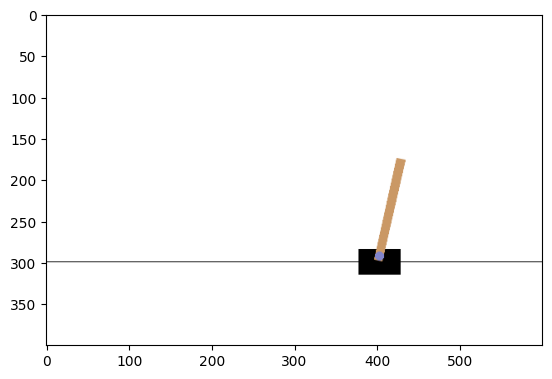

In [7]:
session.test(num_episodes=2)

## III Convergence analysis for different agent configurations

The section above enables us to play around with the A2C-agent and get a feeling for what it is capable of doing. However, as proposed in the goals of this project, I am to set up an agent for continuous action spaces, which should not be so much more challenging altogether, but has up-to-date posed quite a hurdle to me (as demonstrated in the continuous.ipynb)

Anyways, while searching for solutions to get the continuous agent running (browsing through forums, documentation and papers), I discovered that there is a lot to be gained if one experiments with some tweaks to the agent architecture. I wanted to see which of the proposed adaptions would make the discrete action-space agent more effective in order to find out what might help me to solve the continuous action-space agent later!

This chapter is the result of this investigation and will show how much of an impact different **weight-initializers**, **activation-functions** and **normalization-layers** have on training performance.  

### On the adaptions
* **Weight-initializers**: If we manage to initialize the NN-weights in a fortunate manner right from the beginning, training might progress faster
* **Normalization-layers**: 
    * **Normalizing the input to the NN** (based on prior state experiences) the network will act solely on the variance from what it has known to be the average. This might decrease sensibility to inputs with large variance (obsversation space [-inf, inf])
    * **Batch Normalization** Basically does the same in between layers of the NN
* **Activation functions**: This is interesting, because different activation functions obviously return differently fine-grained information of what the input the the layer has been, however, some of them are more costly to compute than others, hence: the ideal activation has to be a compromise of both


### Experiment
In order to demonstrate the differences in training stability and efficiency I trained differently configured agents (until they were capable of solving the 'CartPole-v1'-problem **OR have had 1000 batches = 64 000 steps to train**). 

The resulting policies are safed in the *'training_discrete/pretrained'* folder and there convergence behaviour is visualized below

**Please note, that hyperparameters such as *learning rate*, *batch_size*, *layer_size* etc. have not been altered.**

### Notes regarind TensorBoard
* It might again be necessary to run the block twice
* Untick the failing agents on the left bar in order to 'unsqueeze' the perfromance of those that acutally delivered fast learning results OR BETTER: choose **Settings> General> Horizontal Axis> Relative** on the right side of the DashBoard

In [ ]:
tb_pretrained = os.getcwd()+'/training_discrete/pretrained/'

%tensorboard --logdir {tb_pretrained}

### Some further information and analysis on the graphs above

### 0. BASE VERSION **relue_normal_no_normalization**: did not meet convergence criteria 
2. **relue_normal_state_normalization**: CONVERGED in  379  batches /  24256  steps
2. **relue_normal_state&batch_normalization**: did not meet convergence criteria / collapsed
2. **relue_normal_batch_normalization**: did not meet convergence criteria / collapsed
2. **relue_xavier_no_normalization**: CONVERGED in  427  batches /  27328  steps
2. **mish_xavier_no_normalization**: CONVERGED in  513  batches /  32832  steps
2. **mish_xavier_no_normalization**: CONVERGED in  333  batches /  21312  steps
### 8. BEST VERSION**mish_xavier_state_normalization**: CONVERGED in  330  batches /  21120  steps

## Learnings

* **batch_normalization** does not work great here..
* **state_normalization** does ;)
* **xavier_initialization** seems to smoothen the learning process
* **mish_activation** is a hero

* **low total_loss** (=combined criti, actor and entropy loss over one batch) is not necessarily the best indicator for a good policy

## Finally the best agent's policy demonstrated for 1 episode
### ... chances are: this is a loooong episode

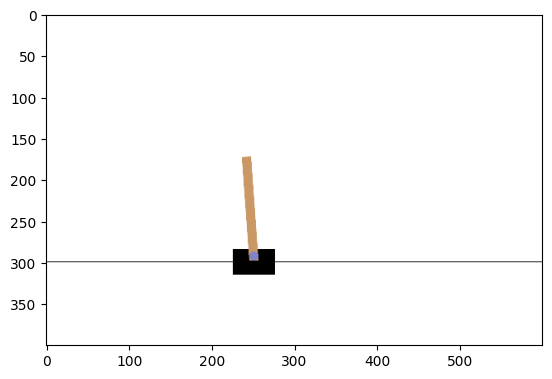

In [8]:
best_session = train.Session(converged_reward_limit=195, specification="TEST_RUN", activation_function='mish', initializer='xavier', state_normalization=True,
          batch_normalization=False, use_existing_policy=True, policy='pretrained/CartPole-v1_mish_normal_STATE_NORMALIZATION/')
best_session.test(num_episodes=1)

## Proof that the agent can also deal with different gym-problems:
**Note: The 'MountainCar-0' is not directly compatible because it's action space maps onto $[-inf,0,inf]$ whereas our agent would return $[0,1,2]$**

**However, 'Acrobat-v1' does work since the action options map onto $[0,1,2]$ (btw. this environment has a 6-D observation_space, so that's more data to work with than 4D-'CartPole-v1')**

**(This environment is a 2-link robot that wants to lift it's center of mass as high as possible)**

**As always: Run block twice!**

In [ ]:
tb_acrobat = os.getcwd()+'/training_discrete/Acrobot-v1_mish_normal_PROOF/'

%tensorboard --logdir {tb_acrobat}

In [ ]:
# acrobat_session = train.Session(converged_reward_limit=-100, env_str="Acrobot-v1", specification="PROOF", activation_function='mish', initializer='normal', state_normalization=False,
#                     batch_normalization=False, use_existing_policy=False)
# acrobat_session.train(max_num_batches=500)

acrobat_session = train.Session(converged_reward_limit=-100, env_str="Acrobot-v1", specification="PROOF", activation_function='mish', initializer='normal', state_normalization=False,
                  batch_normalization=False, use_existing_policy=True, policy='Acrobot-v1_mish_normal_PROOF/')
acrobat_session.test(num_episodes=3)

## Next Stop: *continuous_shared_NN.ipynb* 
#### (this will be a bit less enthusiastic)